In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
os.environ["LANGSMITH_PROJECT"]="TestProject"

In [10]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"

In [11]:
from langchain_groq import ChatGroq
llm = ChatGroq( model_name="llama3-8b-8192")


In [12]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]
## Graph With tool Call
from langchain_core.tools import tool

@tool
def add(a:float,b:float):
    """Add two number"""
    return a+b

tools=[add]
tool_node=ToolNode([add])

llm_with_tool=llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}

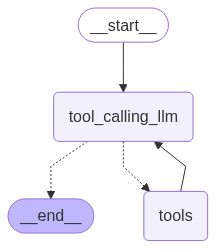

In [13]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
response=graph.invoke({"messages":"What is machine learning"})

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'define_machine_learning' which was not request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "define_machine_learning"\n      },\n      "parameters": {\n        "definition": "Machine learning is a subfield of artificial intelligence that involves training algorithms to learn from data, recognize patterns, and make predictions or decisions without being explicitly programmed."\n      }\n    }\n  ]\n}\n</tool-use>'}}

In [ ]:
response